*Boilerplate de importações necessárias*

In [20]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
print(cv2.__version__)
import os

#Pop-up do Matplotlib
#%matplotlib qt

#Exibição na mesma tela do Jupyter
%matplotlib inline

#plt.rcParams["figure.figsize"]\
#(8,5)

from io import BytesIO
from IPython.display import clear_output, Image, display
import PIL

import datetime

import dlib

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

3.4.2


# Face média da turma 😄

Geração de face média com base nas fotos os alunos do curso, separado por sexo. A ideia deste experimento é evidenciar um pouco sobre como o método de classificação de faces **Eingen Faces** utiliza uma face média para estabelecer aproximações por similaridade.

Para tornar mais preciso, utilizamos uma extração de faces por classificador em cascata de Haar como etapa de normalização inicial.

Nosso dataset se encontra no diretório "eigen-faces". Os arquivos iniciados por h são dos homens e os iniciados por m são das mulheres.

Este código foi adaptado deste [artigo](https://www.learnopencv.com/eigenface-using-opencv-c-python/) de Satya Mallick. O repositório original se encontra neste [link](https://github.com/spmallick/learnopencv/blob/master/EigenFace/EigenFace.py).

In [21]:
# Read images from the directory
def readImages(path, male):
     
    classificador_face = cv2.CascadeClassifier('classificadores/haarcascade_frontalface_default.xml')
    
    # Create array of array of images.
    images = []
    
    # List all files in the directory and read points from text files one by one
    for filePath in sorted(os.listdir(path)):
        fileExt = os.path.splitext(filePath)[1]
        
        f = 0
            
        if fileExt in [".jpg", ".jpeg"]:
            
            
            if male:
                if not filePath.startswith("h"):
                    continue
            else:
                if not filePath.startswith("m"):
                    continue

            # Add to array of images
            imagePath = os.path.join(path, filePath)
            im = cv2.imread(imagePath)
            im_gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            
            face = classificador_face.detectMultiScale(im_gray, 1.3, 3)
            
            for (x,y,w,h) in face:
                roi = im[y:y+h, x:x+w]
                roi = cv2.resize(roi, (100,100))
                # Convert image to floating point
                im = np.float32(roi)/255.0
                # Add image to list
                images.append(im)
                # Flip image 
                imFlip = cv2.flip(im, 1);
                # Append flipped image
                images.append(imFlip)
            
            if face is ():
                print(imagePath)
    
    numImages = int(len(images) / 2)

    print(str(numImages) + " files read.")
    
    return images

In [22]:
def createDataMatrix(images):
    print("Creating data matrix",end=" ... ")

    ''' 
    Allocate space for all images in one data matrix.
    The size of the data matrix is
    ( w  * h  * 3, numImages )
    where,
    w = width of an image in the dataset.
    h = height of an image in the dataset.
    3 is for the 3 color channels.
    '''

    numImages = len(images)
    
    print(numImages)
    
    sz = images[0].shape
    
    print(sz)
    
    
    data = np.zeros((numImages, sz[0] * sz[1] * sz[2]), dtype=np.float32)
    for i in range(0, numImages):
        image = images[i].flatten()
        data[i,:] = image

    print("DONE")
    
    return data

# Realizando um teste com as faces masculinas da turma.

40 files read.
Creating data matrix ... 80
(100, 100, 3)
DONE
Calculating PCA ...DONE


Text(0.5,1,'Torre')

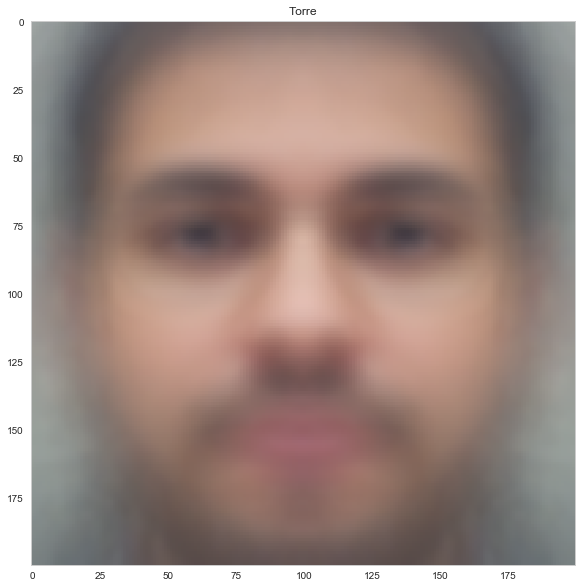

In [16]:
images = readImages("eingen-faces/4ia", True)

# Create data matrix for PCA.
data = createDataMatrix(images)

# Compute the eigenvectors from the stack of images created
print("Calculating PCA ", end="...")
mean, eigenVectors = cv2.PCACompute(data, mean=None)
print("DONE")

sz = images[0].shape

averageFace = mean.reshape(sz)

# Display result at 2x size
output = cv2.resize(averageFace, (0,0), fx=2, fy=2)
output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,10))
plt.imshow(output)
plt.title("Torre")

Incorporando em uma função para poder alterar entre masculino e feminino.

In [33]:
def get_mean_face(male):
    
    # Directory containing images
    dirName = "eingen-faces/4ia"

    # Read images
    images = readImages(dirName, male)

    # Size of images
    sz = images[0].shape

    # Create data matrix for PCA.
    data = createDataMatrix(images)

    # Compute the eigenvectors from the stack of images created
    mean, eigenVectors = cv2.PCACompute(data, mean=None)
    
    eigenFaces = []
    
    for eigenVector in eigenVectors:
        eigenFace = eigenVector.reshape(sz)
        eigenFaces.append(eigenFace)

    averageFace = mean.reshape(sz)

    # Display result at 2x size
    #output = cv2.resize(averageFace, (0,0), fx=2, fy=2)
    output = cv2.cvtColor(averageFace, cv2.COLOR_BGR2RGB)
    
    return output, eigenFaces

40 files read.
Creating data matrix ... 80
(100, 100, 3)
DONE
4 files read.
Creating data matrix ... 8
(100, 100, 3)
DONE


Text(0.5,1,'Face Média Mulher')

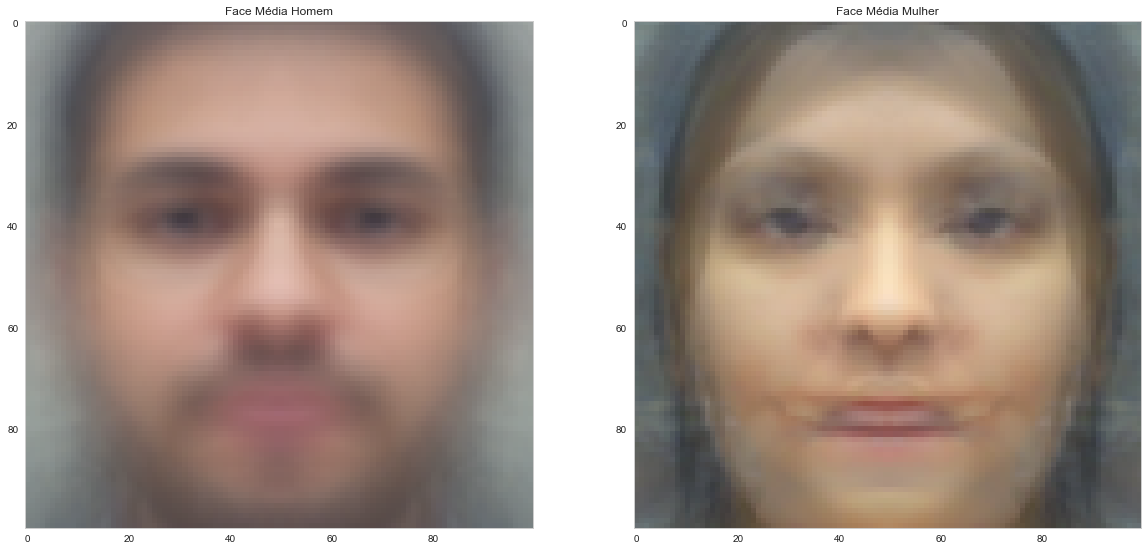

In [34]:
face_media_homem, _ = get_mean_face(True)
face_media_mulher, _ = get_mean_face(False)

plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(face_media_homem)
plt.title("Face Média Homem")

plt.subplot(1,2,2)
plt.imshow(face_media_mulher)
plt.title("Face Média Mulher")

Navegando nos pesos dos componentes principais (PCA), é possível reconstruir novos rostos a partir do espaço de faces criado pelos eingen faces.

Experimente incluir pesos positivos ou negativos, por exemplo -20, -10, 0 (é a média), 10, 20.

In [37]:
def createNewFace(averageFace, weight, eingenface, eigenFaces):
    # Start with the mean image
    output = averageFace

    # Add the eigen faces with the weights
 
    output = np.add(output, eigenFaces[eingenface] * weight)

    # Display Result at 2x size
    output = cv2.resize(output, (0,0), fx=2, fy=2)
    return output

40 files read.
Creating data matrix ... 80
(100, 100, 3)
DONE


Text(0.5,1,'Face Média Homem')

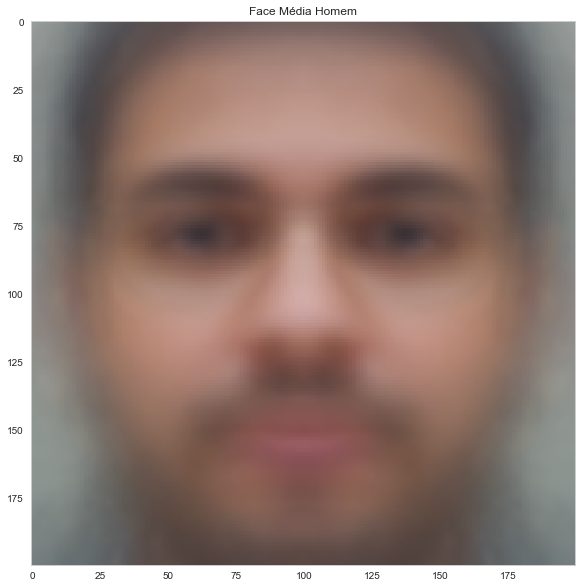

In [38]:
face_media_homem, eingenFaces = get_mean_face(True)
plt.figure(figsize=(10,10))
plt.imshow(createNewFace(face_media_homem, -10, 0, eingenFaces))
plt.title("Face Média Homem")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4 files read.
Creating data matrix ... 8
(100, 100, 3)
DONE


Text(0.5,1,'Face Média Mulher')

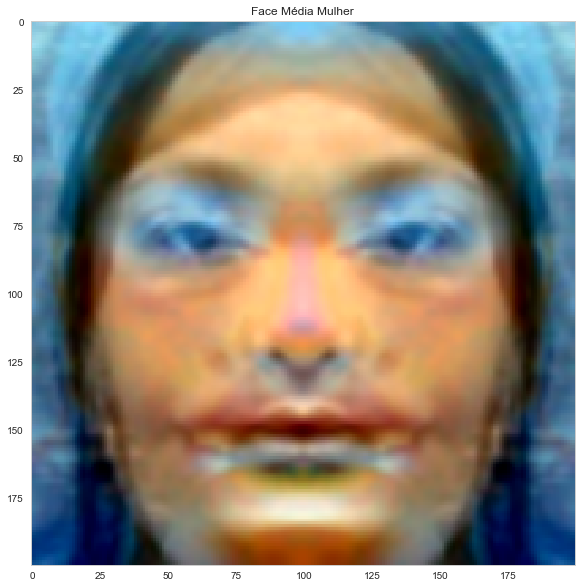

In [42]:
face_media_mulher, eigenFaces = get_mean_face(False)
plt.figure(figsize=(10,10))
plt.imshow(createNewFace(face_media_mulher,-30, 3, eigenFaces))
plt.title("Face Média Mulher")